### <a class="anchor" id="Rank">Executive Summary</a>

The goal of this project is to build a Restaurant Recommender System, which offers restuarant recommendation to users in the city of London

The metrics of the Recommender System is the accuracy of the systems models built:
I. Rank-based Recommender System
II. Content-based Recommender System
III. Collaborative-Fitering Recommender System with Surpise - SVD

The limitations of this project are 
I. Its is computationally expensive
II. Extremtly large data size
       



# Loading the Data & Organizing Catergories

Two datasets were used in this; I. 'Food' Dataset: A dataset constituting of restaurants on in London.
II. 'Users' Dataset: A dataset constituting of user ratings of restaurants in London.

In [84]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file
%matplotlib inline

# this line makes plots prettier on mac retina screens - if you don't have one it shouldn't do anything
%config InlineBackend.figure_format = 'retina'

In [97]:
users = pd.read_csv('users.csv')
del users['Unnamed: 0']
users.shape

(1532640, 3)

In [88]:
food = pd.read_csv('restau_london_final.csv')
del food['Unnamed: 0']
del food['Url']
food.head(2)

,Name,Review,Rating,Category 1,Category 2
0,Amrutha Lounge,425 reviews,5 of 5 bubbles,Indian,££ - £££\nIndian\nAsian\nHealthy\nVegetarian F...
1,Barge East,184 reviews,5 of 5 bubbles,European,££ - £££\nEuropean\nBritish\nContemporary\nFus...


In [96]:
food.Restaurant.nunique()

14424

In [89]:
food.Review = [int(x.replace(',', '').replace('reviews','').replace('review','')) for x in food.Review]
food.Rating = [float(str(x).replace('of 5 bubbles', '')) for x in food.Rating]
food['Category 2'] = [str(x).replace('££ - £££\n','').replace('£\n', '').replace('£££', '').replace('\n', ',').replace(',', ' ') for x in food['Category 2']]
food['Description'] = food['Category 2']
food.head(2)

,Name,Review,Rating,Category 1,Category 2,Description
0,Amrutha Lounge,425,5.0,Indian,Indian Asian Healthy Vegetarian Friendly Vegan...,Indian Asian Healthy Vegetarian Friendly Vegan...
1,Barge East,184,5.0,European,European British Contemporary Fusion Vegetaria...,European British Contemporary Fusion Vegetaria...


In [90]:
lst = [re.findall('V........n', x) for x in food['Category 2']]

new_list = []
for i in lst:
    try:
        if i[0] == 'Vegetarian':
            new_list.append('Vegetarian')
        else:
            new_list.append('Non-Vegetarian')
    except:
        new_list.append('Non-Vegetarian')
        
food['Category 2'] = new_list

In [91]:
other = ['Fast food', 'Seafood', 'International', 'Steakhouse', 'Cafe',  'Vegetarian Friendly', 'Street Food',
        'Fusion', 'Barbecue', 'Healthy', 'Deli', 'Vegan Options', 'Pizza', 'Sushi', 'Soups', 'Gluten Free Options']
east_euro = ['Russian', 'Polish']
euro = ['Irish', 'German', 'French', 'Latin', 'Greek', 'Portuguese', 'Italian', 'British', 'Greek', 'Spanish']
s_american = ['Peruvian', 'Argentinian', 'Venezuelan', 'Cuban', 'Mexican']
african = ['Cajun & Creole', 'Ethiopian']
asian = ['Philippine', 'Taiwanese', 'Pakistani', 'Korean', 'Vietnamese', 'Indian', 'Chinese' , 'Malaysian', 'Japanese', 'Thai', 'Burmese', 'Malaysian', 'Korean']
med = ['Persian', 'Moroccan', 'Turkish']
mid_east = ['Arabic', 'Kosher', 'Halal', 'Lebanese']

def classifier_other(x):

    if x in other:
        return 'General'
    elif x in east_euro:
        return 'Eastern European'
    elif x in euro:
        return 'European'
    elif x in s_american:
        return 'South American'
    elif x in african:
        return 'African'
    elif x in med:
        return 'Mediterranean'
    elif x in asian:
        return 'Asian'
    elif x in mid_east:
        return 'Middle Eastern'
    elif x == 'Jamaican':
        return 'Caribbean'
    elif x == 'Hawaiian':
        return 'American'
    else:
        return x

food['Category 1'] = food['Category 1'].apply(classifier_other)
food.head(2)

,Name,Review,Rating,Category 1,Category 2,Description
0,Amrutha Lounge,425,5.0,Asian,Vegetarian,Indian Asian Healthy Vegetarian Friendly Vegan...
1,Barge East,184,5.0,European,Vegetarian,European British Contemporary Fusion Vegetaria...


In [ ]:
food.rename(columns={'Name': 'Restaurant', 'Food_id': 'Restaurant_id'}, inplace=True)



In [93]:
#Creating unique ids for restaurant names
print('The number of unique food names are {}' .format(food['Name'].nunique()))


#Dictionary for mapping restuarant to unique ids
restaurant_dict = {}


for id, name in enumerate(food['Name'].unique(), 1):
    
    restaurant_dict[name] = id
    
food['Restaurant_id'] = food['Name'].map(restaurant_dict)
food.head()

#Rearranging columns to have food_id with name
new_order = [0, 6, 1, 2, 3, 4, 5]

food = food[food.columns[new_order]]

food.head()


The number of unique food names are 14424


,Name,Restaurant_id,Review,Rating,Category 1,Category 2,Description
0,Amrutha Lounge,1,425,5.0,Asian,Vegetarian,Indian Asian Healthy Vegetarian Friendly Vegan...
1,Barge East,2,184,5.0,European,Vegetarian,European British Contemporary Fusion Vegetaria...
2,Latitude,3,78,5.0,European,Vegetarian,European International British Vegetarian Frie...
3,Dobar,4,107,5.0,General,Vegetarian,Pizza Cafe British Vegetarian Friendly Vegan O...
4,Chojo,5,199,5.0,Asian,Vegetarian,Chinese Taiwanese Street Food Vegetarian Frien...


In [94]:
food.rename(columns={'Name': 'Restaurant', 'Food_id': 'Restaurant_id'}, inplace=True)
food.head()

,Restaurant,Restaurant_id,Review,Rating,Category 1,Category 2,Description
0,Amrutha Lounge,1,425,5.0,Asian,Vegetarian,Indian Asian Healthy Vegetarian Friendly Vegan...
1,Barge East,2,184,5.0,European,Vegetarian,European British Contemporary Fusion Vegetaria...
2,Latitude,3,78,5.0,European,Vegetarian,European International British Vegetarian Frie...
3,Dobar,4,107,5.0,General,Vegetarian,Pizza Cafe British Vegetarian Friendly Vegan O...
4,Chojo,5,199,5.0,Asian,Vegetarian,Chinese Taiwanese Street Food Vegetarian Frien...


In [13]:
#Gathering unique set of all food categories

categories_list = []

for i in food['Description']:
    
    try:
        
        categories_list.extend(i.split(' '))
        
    except AttributeError:
        
        pass
    

# Our unique set of food categories
categories = set(categories_list)

print("The number of food categories is {}.".format(len(categories)))

The number of food categories is 134.


In [14]:
# Function to split and return values for columns
def split_categories(val):
    try:
        if val.find(category) >-1:
            return 1
        else:
            return 0
    except AttributeError:
        return 0

# Apply function for each category
for category in categories:        
    food[category] = food['Description'].apply(split_categories)
    
#food.set_index(['Food_id'])

In [16]:
#Saving dictionary to ensure consistency when used in users dataframe
import pickle
f = open("restaurant_dict.pkl","wb")
pickle.dump(restaurant_dict,f)
f.close()

In [17]:
# loading the other dataset

users = pd.read_csv('users_names.csv')
del users['Unnamed: 0']
users.head(2)

,Name,User_id,Restaurant,Restaurant_id,Rating
0,"Dr_Rebecca_PLondon, United Kingdom",1,Street Feast Model Market,3468,4.0
1,"Karen GKent, United Kingdom",2,Street Feast Model Market,3468,2.0


In [18]:
3468 in list(restaurant_dict.values())

restaurant_dict['Street Feast Model Market']

unique_dict = set(restaurant_dict.keys())
unique_rest_users = set(users['Restaurant'].unique())

intersection_dict = len(unique_dict.intersection(unique_rest_users))
intersection_users = len(unique_rest_users.intersection(unique_dict))


print(len(unique_dict), '\n', len(unique_rest_users), intersection_dict, intersection_users)

14424 
 13586 13520 13520


In [19]:
users.Restaurant_id = users.Restaurant_id.sort_values(ascending=True)
users.head(2)

,Name,User_id,Restaurant,Restaurant_id,Rating
0,"Dr_Rebecca_PLondon, United Kingdom",1,Street Feast Model Market,3468,4.0
1,"Karen GKent, United Kingdom",2,Street Feast Model Market,3468,2.0


## <a class="anchor" id="Rank">Simple EDA</a>

In [30]:
# we do some simple eda to have an idea of the average amount of time each user has rated a restaurant

groupby=users.groupby(['User_id']).count()

In [32]:
groupby['log_counts']=groupby['Rating'].apply(lambda x:np.log(x))

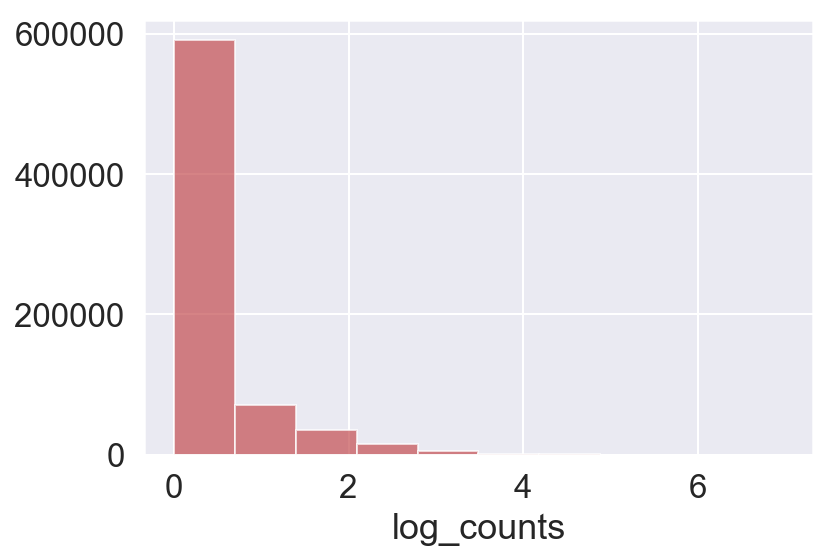

In [48]:
sns.distplot(groupby['log_counts'],kde=False,bins=10, color='r', hist_kws=dict(alpha=0.7))

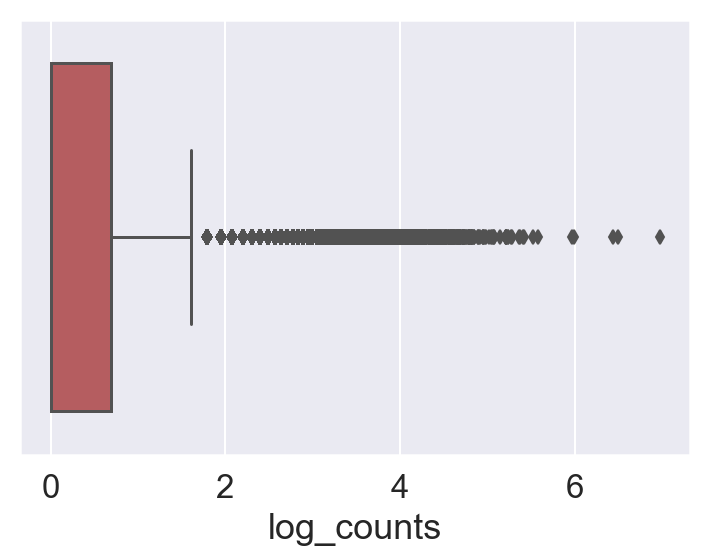

In [39]:
sns.boxplot(groupby['log_counts'], color ='r')

# Modelling

## <a class="anchor" id="Rank">Part I: Rank-Based Recommendations</a>

In [51]:

food.rename(columns={'Name': 'Restaurant', 'Food_id': 'Restaurant_id'}, inplace=True)

food_copy = food.copy()


In [52]:
def create_ranked_df(users):
        '''
        INPUT
        restuarants - the restuarants dataframe
        reviews - the reviews dataframe
        
        OUTPUT
        ranked_restuarants - a dataframe with restuarants that are sorted by highest avg ratinga and most reviews, 
        also must have more than 3 ratings
        '''
        
        # Pull the average ratings and number of ratings for each restuarant
        rest_ratings = users.groupby('Restaurant_id')['Rating'] #select restuarant id, gather and put all ratings for restuarant id
        avg_ratings = rest_ratings.mean()
        num_ratings = rest_ratings.count()
        
        # Add Dates
        rating_count_df = pd.DataFrame({'Avg_rating': avg_ratings, 'Num_ratings': num_ratings})
    
        return rating_count_df

        


In [53]:
def apply_avg_last(x):
    
    rating_count_df = create_ranked_df(users)
    
    available_index = list( rating_count_df.index)
    
    if x in available_index:
        
        return rating_count_df['Avg_rating'].loc[rating_count_df.index == x].values[0]
    
    else:
        
        return np.nan

In [54]:
def apply_num_last(x):
    
    rating_count_df = create_ranked_df(users)
    
    available_index = list( rating_count_df.index)
    
    if x in available_index:
        
        return rating_count_df['Num_ratings'].loc[rating_count_df.index == x].values[0]
    
    else:
        
        return np.nan

In [ ]:

food_copy['Avg_rating'] = food_copy['Restaurant_id'].apply(apply_avg_last)

food_copy['Num_rating'] = food_copy['Restaurant_id'].apply(apply_num_last)

food_copy.to_csv('ranking_copy.csv')



In [56]:
food_copy = pd.read_csv('ranking_copy.csv')

del food_copy['Unnamed: 0']
food_copy.head(2)

,Restaurant,Restaurant_id,Review,Rating,Category 1,Category 2,Description,Mexican,Russian,South,...,Nepalese,Wine,Canadian,Indian,Tibetan,Sushi,Deli,Peruvian,Avg_rating,Num_rating
0,Amrutha Lounge,1,425,5.0,Asian,Vegetarian,Indian Asian Healthy Vegetarian Friendly Vegan...,0,0,0,...,0,0,0,1,0,0,0,0,4.918919,407.0
1,Barge East,2,184,5.0,European,Vegetarian,European British Contemporary Fusion Vegetaria...,0,0,0,...,0,0,0,0,0,0,0,0,4.923077,182.0


In [57]:

# merge with the movies dataset
        #movie_recs = movies.set_index('movie_id').join(rating_count_df)

# sort by top avg rating and number of ratings

def created_ranked_sorted():
    
    ranked_restaurants = food_copy.sort_values(['Avg_rating', 'Num_rating'], ascending=False)

    # for edge cases - subset the movie list to those with only 5 or more reviews
    ranked_restaurants = ranked_restaurants[ranked_restaurants['Num_rating'] > 4]
        
    return ranked_restaurants

In [58]:
def popular_recommendations(user_id, n_top, ranked_restaurants):
    '''
    INPUT:
    user_id - the user_id (str) of the individual you are making recommendations for
    n_top - an integer of the number recommendations you want back
    ranked_restaurants - a pandas dataframe of the already ranked Restaurants based on avg rating and count

    OUTPUT:
    top_restuarants - a list of the n_top recommended Restaurants by Restaurant title in order best to worst
    '''

    top_restuarants = list(ranked_restaurants['Restaurant'][:n_top])

    return top_restuarants
        





In [59]:
created_ranked_sorted().head(2)

,Restaurant,Restaurant_id,Review,Rating,Category 1,Category 2,Description,Mexican,Russian,South,...,Nepalese,Wine,Canadian,Indian,Tibetan,Sushi,Deli,Peruvian,Avg_rating,Num_rating
1609,Spanish Particular,1585,44,5.0,Mediterranean,Vegetarian,Mediterranean Spanish European Vegetarian Frie...,0,0,0,...,0,0,0,0,0,0,0,0,5.0,44.0
1142,Rotate,1129,41,5.0,General,Non-Vegetarian,Bar Cafe Asian Pub Taiwanese,0,0,0,...,0,0,0,0,0,0,0,0,5.0,41.0


In [60]:
# Rank-based Recommender Example

ranked_restaurants = created_ranked_sorted() # only run this once - it is not fast

# Top 5 restaurants recommended for user 53968
recs_5_for_53968 = popular_recommendations('53968', 5, ranked_restaurants)

# Top 20 restaurants recommended for user 8
recs_20_for_8 = popular_recommendations('8', 10, ranked_restaurants)

# Top 50 restaurants recommended for user 43
recs_50_for_43 = popular_recommendations('43', 50, ranked_restaurants)

# Top 100 restaurants recommended for user 70000
recs_100_for_70000 = popular_recommendations('70000', 100, ranked_restaurants)

print(' Top 5 Recommended for User 53968:\n',recs_5_for_53968)

 Top 5 Recommended for User 53968:
 ['Spanish Particular', 'Rotate', 'Companero', 'Slaw', 'Tummy Kom4ort Nigerian Restaurant (African Cuisine)']


In [62]:
def popular_recs_filtered(user_id, n_top, ranked_restaurants, cat1=None, cat2=None):
    '''
    INPUT:
    user_id - the user_id (str) of the individual you are making recommendations for
    n_top - an integer of the number recommendations you want back
    ranked_restaurants - a pandas dataframe of the already ranked restaurants based on avg rating and count
    cat1 - a list of strings with cuisines of restaurants
    cat2 - a list of strings with food choices of restaurants
    
    OUTPUT:
    ranked_restaurants - a list of the n_top recommended restaurants by restaurant title in order best to worst
    '''
    # Filter movies based on cat1 and cat2
    if cat1 is not None:
        num_cat1_match = ranked_restaurants[cat1].sum(axis=1)
        ranked_restaurants = ranked_restaurants.loc[num_cat1_match > 0, :]
        
    if cat2 is not None:
        num_cat2_match = ranked_restaurants[cat2].sum(axis=1)
        ranked_restaurants = ranked_restaurants.loc[num_cat2_match > 0, :]
            
            
    # create top movies list 
    top_restaurants = list(ranked_restaurants['Restaurant'][:n_top])

    return top_restaurants



In [77]:

# Top restaurants recommended for users based on categories=['British', 'Vegetarian']

recs_5_for_user7_filtered = popular_recs_filtered('7', 5, ranked_restaurants, cat1=['British'])

recs_5_for_user2_filtered = popular_recs_filtered('2', 5, ranked_restaurants, cat2=['Vegetarian'])



In [78]:
recs_5_for_user2_filtered

['Spanish Particular',
 'Slaw',
 'Tummy Kom4ort Nigerian Restaurant (African Cuisine)',
 'Marcel & Sons',
 'The Wagon @ cave']

In [79]:
recs_5_for_user7_filtered

['Slaw',
 'Long & Short Coffee',
 'Cart and Horses',
 'The Wagon @ cave',
 'Hodge Podge']

In [ ]:


# notes
# after this, it will be good to test the precision and recall
# and also check similarity 

## <a class="anchor" id="Rank">Part II: Content-based Recommendations</a>

In [102]:
food.shape

(16403, 7)

In [60]:
del food['nan']
food.shape

(16403, 140)

In [65]:
#Creating extra category for the food Cuisine Categories
# Our unique set of food cuisines

cuisines =list(food['Category 1'].unique())

cuisines.remove(np.nan)
print("The number of food categories is {}.".format(len(cuisines)))
print(cuisines)

The number of food categories is 10.
['Asian', 'European', 'General', 'Mediterranean', 'American', 'South American', 'African', 'Middle Eastern', 'Caribbean', 'Eastern European']


In [69]:
# Function to split and return values for columns
def split_cuisines(cus):
    try:
        if cus.find(cuisine) >-1:
            return 1
        else:
            return 0
    except AttributeError:
        return 0

# Apply function for each category
for cuisine in cuisines:        
    food[cuisine] = food['Category 1'].apply(split_cuisines)
    
food.head(2)

,Restaurant,Restaurant_id,Review,Rating,Category 1,Category 2,Description,Eastern,Israeli,Polynesian,...,Hawaiian,Pakistani,Fusion,Swedish,Greek,Caucasian,General,South American,Middle Eastern,Eastern European
0,Amrutha Lounge,1,425,5.0,Asian,Vegetarian,Indian Asian Healthy Vegetarian Friendly Vegan...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barge East,2,184,5.0,European,Vegetarian,European British Contemporary Fusion Vegetaria...,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [70]:
food_content_based = food.drop(['Review', 'Rating', 'Category 1', 'Category 2', 'Description' ], axis = 1)
food_content_based.head(2)

,Restaurant,Restaurant_id,Eastern,Israeli,Polynesian,Lankan,Cafe,Swiss,Moroccan,Middle,...,Hawaiian,Pakistani,Fusion,Swedish,Greek,Caucasian,General,South American,Middle Eastern,Eastern European
0,Amrutha Lounge,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barge East,2,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [71]:
#Creating Content similairty using Dot Product-Based Similarity (Since all same scale - 1 & 0s)

def content_similarity(food_content_based, Restaurant_id, m):
    
    #This function returns m similar restaurants for a given id
    
    Restaurant_idx = np.where(food_content_based['Restaurant_id'] == Restaurant_id)[0][0]

    Restaurant_content = np.array(food_content_based.iloc[Restaurant_idx, 2:])
    
    all_Restaurant = np.array(food_content_based.iloc[:, 2:])
    
    dotprod = np.dot(Restaurant_content, all_Restaurant.T)
    
    similar_idxs = list(dotprod.argsort()[::-1])
    
    #Removing input Restaurant id from our content list
    similar_idxs.remove(Restaurant_idx)
    
    similar_restaurants = list(food.iloc[similar_idxs, ]['Restaurant'])
    
    similar_description =  list (food.iloc[similar_idxs, ]['Description'])
    
    content_with_description = pd.DataFrame({'restaurants' : similar_restaurants, 'description' : similar_description})
    
    return similar_restaurants[:m], similar_description[:m], content_with_description[:m]



In [72]:
#Given a restaurant id, we can pull restaurants with similar contents- Their names, description or dataframe containing both.

recs_id = 9000
recommendation_names, recommendation_Description, content_with_description = content_similarity(food_content_based, recs_id,10)

In [73]:
#Test of content- Indicating the restaurant_id in our iloc indexing

print(food['Restaurant'].loc[food.Restaurant_id == recs_id].values[0])
print(food['Description'].loc[food.Restaurant_id == recs_id].values[0])
print('\n')
content_with_description

Piacere
Cafe British Vegetarian Friendly




,restaurants,description
0,Coco Momo,Bar Cafe European British Vegetarian Friendly ...
1,Saint Aymes,Cafe British Vegetarian Friendly
2,Giovanni's,Cafe British Italian Vegetarian Friendly
3,RA Grand Cafe,Cafe British Vegetarian Friendly Vegan Options
4,Baker & Spice - Chelsea,Cafe British Vegetarian Friendly Gluten Free O...
5,Cafe Nuvo,Cafe British Vegetarian Friendly Vegan Options
6,Oxleas Wood Cafe,Cafe British Vegetarian Friendly
7,Pitfield,Cafe British Vegetarian Friendly Vegan Options
8,Cafe Maya,Cafe British Vegetarian Friendly Vegan Options...
9,Melrose and Morgan,Cafe British Deli Vegetarian Friendly


## <a class="anchor" id="Rank">Part III: Collaborative Filtering - Recommendations with Surprise</a>

In [1]:
import pandas as pd
import numpy as np
import re
import surprise as sur
users = pd.read_csv('users.csv')
del users['Unnamed: 0']
users.head(2)

,User_id,Restaurant_id,Rating
0,1,3468,4.0
1,2,3468,2.0


In [3]:
# We have the option of only using users who have rated five times or more for the collaborative filtering

users_5plus = users.groupby('User_id')['Rating'].filter(lambda x: len(x) >= 5)

In [4]:
users.Rating.shape

(1532640,)

In [5]:
algo = sur.SVD()
reader = sur.Reader(rating_scale=(1, 5))

data = sur.Dataset.load_from_df(
    users[['User_id', 'Restaurant_id', 'Rating']], reader)

In [6]:
# Train-test Split 

import random

raw_ratings = data.raw_ratings
np.random.seed(1)
# shuffle ratings if you want
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

print(len(A_raw_ratings))
print(len(B_raw_ratings))

data.raw_ratings = A_raw_ratings  # data is now the set A

1226112
306528


In [7]:
# new import 


In [8]:
# Select your best algo with grid search.
print('Grid Search...')
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005]}
grid_search = sur.model_selection.GridSearchCV(sur.SVD,
                                               param_grid,
                                               measures=['rmse'],
                                               cv=3,
                                               refit=True)
grid_search.fit(data)

algo = grid_search.best_estimator['rmse']

Grid Search...


In [9]:

# retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute score on training set
trainset_build = trainset.build_testset()
predictions_train = algo.test(trainset_build)
print('Training score ', end='   ')
sur.accuracy.rmse(predictions_train)

Training score    RMSE: 0.9857


0.9857493531400184

In [10]:


# Compute score on rated test set
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions_test = algo.test(testset)
print('Test score (rated items) ', end=' ')
sur.accuracy.rmse(predictions_test)

Test score (rated items)  RMSE: 1.1615


1.1614973653278833

In [20]:
predicted_rating = algo.predict('User_id', 'Restaurant_id')

In [21]:
predicted_rating

Prediction(uid='User_id', iid='Restaurant_id', r_ui=None, est=4.007939731443783, details={'was_impossible': False})

In [8]:
cv_results = sur.model_selection.cross_validate(
    algo, data, measures=['RMSE', 'MAE'], cv=5)
cv_dataframe = pd.DataFrame(cv_results)
cv_dataframe

,test_rmse,test_mae,fit_time,test_time
0,1.162213,0.907097,41.903487,2.580908
1,1.164951,0.907189,40.583754,2.388872
2,1.162572,0.906678,41.105378,3.979517
3,1.166102,0.908980,41.259456,4.029003
4,1.163442,0.908003,41.238984,2.411928


In [9]:
# Cross-Val Score of Model

cv_dataframe.test_rmse.mean()

1.163856064408952

In [10]:
from collections import defaultdict


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    f1s = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

        # F1@K:
        f1s[uid] = 2*precisions[uid]*recalls[uid] / \
            (precisions[uid]+recalls[uid]
             ) if (precisions[uid]+recalls[uid]) != 0 else 1

    return precisions, recalls, f1s

In [11]:
precisions, recalls, f1s = precision_recall_at_k(
    predictions_train, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(np.mean(list(precisions.values())))
print(np.mean(list(recalls.values())))
print(np.mean(list(f1s.values())))

0.9569153107551919
0.7678280312701565
0.7640922315033734


In [12]:
precisions, recalls, f1s = precision_recall_at_k(
    predictions_test, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(np.mean(list(precisions.values())))
print(np.mean(list(recalls.values())))
print(np.mean(list(f1s.values())))

0.9049418327906933
0.7122960020500408
0.6409856114512541


In [13]:
from collections import defaultdict


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [14]:
top_n = {}
top_n = get_top_n(predictions_train, n=10)
len(top_n.keys())

667755

In [15]:
top_n_list = []
for key in top_n.keys():
    for val in top_n[key]:
        top_n_list.append([key, val[0], val[1]])
        
len(top_n_list)

1236961

In [16]:
df_top = pd.DataFrame(top_n_list, columns=['uid', 'iid', 'est'])
df_top.head()

,uid,iid,est
0,729,70,4.402608
1,729,1570,4.342670
2,729,1570,4.342670
3,729,91,4.329615
4,729,91,4.329615
